In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords   
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from underthesea import word_tokenize

In [2]:
import warnings
warnings.filterwarnings('ignore')
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt')
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (17,7)
plt.rcParams['font.size'] = 18

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Before pre-processing

In [3]:
import pandas as pd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

data = pd.read_csv("Dataset/vsa_food_rv_train.csv", encoding="utf-8")
    
data.head(10)

,Comment,Rating
0,Món ăn cực tệ,0.0
1,Mình thấy mọi người review tích cực nhưng thực sự mình không thấy lẩu ở đây giống review. Lẩu đắt và chán thực sự. Never come back!,0.0
2,"Chắc với sinh viên thì ai cũng quen thuộc với lẩu Nguyệt. Cứ có dịp gì tụ tập đông đông là nhóm mình lại qua đây ăn. Vừa ngon vừa rẻ. Quán thì phải kéo dài từ vỉa hè đến cả trong ngõ 106, có cả ngồi dưới nhà và đi thang máy lên tầng tùy mình muốn chọn ngồi đâu thì ngồi.\n Quán cũng chỉ có 2 loại lẩu: lẩu riêu cua và lẩu hải sản. Nhân viên thường lấy đồ theo kiểu 100k/ người. Lẩu riêu cua nếu đi 7 người thì cũng chỉ gọi phần cho 5 người thôi, không sẽ không hết vì quá nhiều )). Thường bọn mình sẽ gọi thêm 1 đĩa lòng, tràng, trứng gà non 100k/ đĩa ăn kèm. Còn lẩu hải sản cũng khá đầy đặn 350k/ nồi. Quán cũng bán thêm quẩy ăn kèm lẩu nữa. Nói chung ăn ở đây cứ chia đầu người 120k là no lắm rồi ý ^^.",1.0
3,"Nhiều hôm thèm lẩu riêu mà chỉ có một mình thì nên ra đây để ăn vì giá rổ rất phải chăng để có thể không cần đồng bọn.\nTết nhất ngán thịt thì có thể qua đây vì lẩu ở đây cực nhiều đậu. Thuộc thể loại ăn lẩu thích ăn rau nhiều hơn thịt nên quán này cực hợp với mình. Gọi nồi lẩu 2 người không thêm gì khác cũng đủ no căng bụng rồi. Topping ở đây còn có cả chả cá, chả bò, giò tai cực ngon. Ăn một người cũng hết 200k thui à.",1.0
4,Không gian sạch sẽ.quán mới lên ra món hơi chậm.15p chờ cũng ko lâu lắm.nhưng đồ đều nóng thơm lừng.nhiều nữa chứ.,1.0
5,Nhất định sẽ ủng hộ quán dài dài…,1.0
6,Lang thang với cái bụng đói.đứng chờ tàu thì ngó thấy.quay xe đi vào.lúc đầu nghĩ là nhầm quán cafe cơ.vì bàn ghê đẹp.có hai cô chỉ cũng đẹp luôn.đói mạnh dạn gọi hẳn đặc biệt 60k.\nĂn ngon nhiều.còn bán rượu khá ngon.đồ đủ để hai ng ngồi nhấm vài ly luôn.\nNói chung 5 sao,1.0
7,"Cá thái quá to, rán cháy, cứng, khô.\nNước dùng chán, nhạt",0.0
8,"Đói quá vội ăn nên ko chụp đc cái ảnh tử tế. Phải nói là bún cá ở đây ngon nhất trong các quán đã ăn. \nMình ăn thử rất rất nhiều quán, cả các quán nổi tiếng lẫn các quán nhỏ nhưng ko ở đâu làm ổn như ở đây. \nNước dùng đậm đà, màu sắc bắt mắt chứ ko trắng nhởn như nhiều quán khác. Cá thì to bự cắn đã cái mồm, giòn tan luôn nhưng ko hề bị khô. Theo thói quen mình mua thêm cá vì các quán khác cho cá rất ít. Còn ở đây cá của 1 suất thôi cũng nhiều hơn hẳn các quán khác, thực sự to và nhiều cực luôn. Có vài miếng cá nhiều xương nhưng chấp nhận đc vì ngon. Nước chấm cũng ngon khỏi bàn. Đồ kèm theo chuẩn bị đầy đủ.\nThái độ bán hàng cũng tốt. Nếu là quán khác thì cứ tự ý mà cho theo ý mình thôi. Còn ở đây gọi lịch sự hỏi khách ăn rau cần đc ko vì tạm thời ko có cải. Vậy mà khi nhận đồ vẫn đc cả 2 suất rau cải. \nĐến anh chồng Nhật khó tính cũng phải khen là tốt nhất từ trc đến nay.\nHy vọng lần sau ăn sẽ ko có gì thay đổi.",1.0
9,"Mình vẫn k hiểu vì sao quán mở được đến tận 7-8 cơ sở tại HN và SG )))) Đồ ăn ở mức trung bình, nước lẩu thái chả có gì đặc sắc. Nồi lẩu nhỏ hơn 300k ăn lèo tèo vài miếng thịt, tôm bở ko tươi, nấm cho 2 người ăn được 1 nhúm. Món cánh gà tre ăn tạm ổn nhất, xôi xoài ăn rõ chán, xoài nhũn và nhạt nhẽo. Giá quá đắt so với những gì đã được trải nghiệm.",0.0


### Xử lý Nan

In [4]:
data['Comment'].isna().sum()

4

In [5]:
data['Rating'].isna().sum()

6

In [6]:
data = data.dropna()
data = data.reset_index(drop=True)

In [7]:
data['Rating'].value_counts()

Rating
1.0    17351
0.0     5490
Name: count, dtype: int64

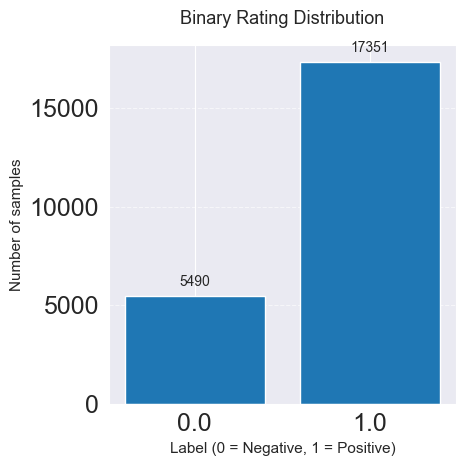

In [45]:
import matplotlib.pyplot as plt

rating_counts = data['Rating'].value_counts().sort_index()

plt.figure(figsize=(5, 5))  
bars = plt.bar(
    rating_counts.index.astype(str),
    rating_counts.values
)

plt.xlabel("Label (0 = Negative, 1 = Positive)", fontsize=11)
plt.ylabel("Number of samples", fontsize=11)
plt.title("Binary Rating Distribution", fontsize=13, pad=15)  

plt.grid(axis='y', linestyle='--', alpha=0.6)

max_height = rating_counts.values.max()

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + max_height * 0.02,
        int(height),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()


# Exploratory Data Analysis

### Độ dài của câu hỏi được tính theo số ký tự.

In [8]:
lenght = len(data['Comment'][0])
print(f'Độ dài của mẫu đầu tiên: {lenght}')

Độ dài của mẫu đầu tiên: 13


In [9]:
data['Length'] = data['Comment'].str.len()
data.head(10)

,Comment,Rating,Length
0,Món ăn cực tệ,0.0,13
1,Mình thấy mọi người review tích cực nhưng thực sự mình không thấy lẩu ở đây giống review. Lẩu đắt và chán thực sự. Never come back!,0.0,131
2,"Chắc với sinh viên thì ai cũng quen thuộc với lẩu Nguyệt. Cứ có dịp gì tụ tập đông đông là nhóm mình lại qua đây ăn. Vừa ngon vừa rẻ. Quán thì phải kéo dài từ vỉa hè đến cả trong ngõ 106, có cả ngồi dưới nhà và đi thang máy lên tầng tùy mình muốn chọn ngồi đâu thì ngồi.\n Quán cũng chỉ có 2 loại lẩu: lẩu riêu cua và lẩu hải sản. Nhân viên thường lấy đồ theo kiểu 100k/ người. Lẩu riêu cua nếu đi 7 người thì cũng chỉ gọi phần cho 5 người thôi, không sẽ không hết vì quá nhiều )). Thường bọn mình sẽ gọi thêm 1 đĩa lòng, tràng, trứng gà non 100k/ đĩa ăn kèm. Còn lẩu hải sản cũng khá đầy đặn 350k/ nồi. Quán cũng bán thêm quẩy ăn kèm lẩu nữa. Nói chung ăn ở đây cứ chia đầu người 120k là no lắm rồi ý ^^.",1.0,704
3,"Nhiều hôm thèm lẩu riêu mà chỉ có một mình thì nên ra đây để ăn vì giá rổ rất phải chăng để có thể không cần đồng bọn.\nTết nhất ngán thịt thì có thể qua đây vì lẩu ở đây cực nhiều đậu. Thuộc thể loại ăn lẩu thích ăn rau nhiều hơn thịt nên quán này cực hợp với mình. Gọi nồi lẩu 2 người không thêm gì khác cũng đủ no căng bụng rồi. Topping ở đây còn có cả chả cá, chả bò, giò tai cực ngon. Ăn một người cũng hết 200k thui à.",1.0,423
4,Không gian sạch sẽ.quán mới lên ra món hơi chậm.15p chờ cũng ko lâu lắm.nhưng đồ đều nóng thơm lừng.nhiều nữa chứ.,1.0,114
5,Nhất định sẽ ủng hộ quán dài dài…,1.0,33
6,Lang thang với cái bụng đói.đứng chờ tàu thì ngó thấy.quay xe đi vào.lúc đầu nghĩ là nhầm quán cafe cơ.vì bàn ghê đẹp.có hai cô chỉ cũng đẹp luôn.đói mạnh dạn gọi hẳn đặc biệt 60k.\nĂn ngon nhiều.còn bán rượu khá ngon.đồ đủ để hai ng ngồi nhấm vài ly luôn.\nNói chung 5 sao,1.0,271
7,"Cá thái quá to, rán cháy, cứng, khô.\nNước dùng chán, nhạt",0.0,57
8,"Đói quá vội ăn nên ko chụp đc cái ảnh tử tế. Phải nói là bún cá ở đây ngon nhất trong các quán đã ăn. \nMình ăn thử rất rất nhiều quán, cả các quán nổi tiếng lẫn các quán nhỏ nhưng ko ở đâu làm ổn như ở đây. \nNước dùng đậm đà, màu sắc bắt mắt chứ ko trắng nhởn như nhiều quán khác. Cá thì to bự cắn đã cái mồm, giòn tan luôn nhưng ko hề bị khô. Theo thói quen mình mua thêm cá vì các quán khác cho cá rất ít. Còn ở đây cá của 1 suất thôi cũng nhiều hơn hẳn các quán khác, thực sự to và nhiều cực luôn. Có vài miếng cá nhiều xương nhưng chấp nhận đc vì ngon. Nước chấm cũng ngon khỏi bàn. Đồ kèm theo chuẩn bị đầy đủ.\nThái độ bán hàng cũng tốt. Nếu là quán khác thì cứ tự ý mà cho theo ý mình thôi. Còn ở đây gọi lịch sự hỏi khách ăn rau cần đc ko vì tạm thời ko có cải. Vậy mà khi nhận đồ vẫn đc cả 2 suất rau cải. \nĐến anh chồng Nhật khó tính cũng phải khen là tốt nhất từ trc đến nay.\nHy vọng lần sau ăn sẽ ko có gì thay đổi.",1.0,926
9,"Mình vẫn k hiểu vì sao quán mở được đến tận 7-8 cơ sở tại HN và SG )))) Đồ ăn ở mức trung bình, nước lẩu thái chả có gì đặc sắc. Nồi lẩu nhỏ hơn 300k ăn lèo tèo vài miếng thịt, tôm bở ko tươi, nấm cho 2 người ăn được 1 nhúm. Món cánh gà tre ăn tạm ổn nhất, xôi xoài ăn rõ chán, xoài nhũn và nhạt nhẽo. Giá quá đắt so với những gì đã được trải nghiệm.",0.0,350


### Số từ trong mỗi câu được tính bằng cách đếm các từ trong cột Comment

In [10]:
word_count = data['Comment'][0].split()
print(f'Số từ trong mẫu đầu tiên: {len(word_count)}')

Số từ trong mẫu đầu tiên: 4


In [11]:
def word_count(review):
    review_list = review.split()
    return len(review_list)

data['Word_count'] = data['Comment'].apply(word_count)
data.head(10)

,Comment,Rating,Length,Word_count
0,Món ăn cực tệ,0.0,13,4
1,Mình thấy mọi người review tích cực nhưng thực sự mình không thấy lẩu ở đây giống review. Lẩu đắt và chán thực sự. Never come back!,0.0,131,27
2,"Chắc với sinh viên thì ai cũng quen thuộc với lẩu Nguyệt. Cứ có dịp gì tụ tập đông đông là nhóm mình lại qua đây ăn. Vừa ngon vừa rẻ. Quán thì phải kéo dài từ vỉa hè đến cả trong ngõ 106, có cả ngồi dưới nhà và đi thang máy lên tầng tùy mình muốn chọn ngồi đâu thì ngồi.\n Quán cũng chỉ có 2 loại lẩu: lẩu riêu cua và lẩu hải sản. Nhân viên thường lấy đồ theo kiểu 100k/ người. Lẩu riêu cua nếu đi 7 người thì cũng chỉ gọi phần cho 5 người thôi, không sẽ không hết vì quá nhiều )). Thường bọn mình sẽ gọi thêm 1 đĩa lòng, tràng, trứng gà non 100k/ đĩa ăn kèm. Còn lẩu hải sản cũng khá đầy đặn 350k/ nồi. Quán cũng bán thêm quẩy ăn kèm lẩu nữa. Nói chung ăn ở đây cứ chia đầu người 120k là no lắm rồi ý ^^.",1.0,704,162
3,"Nhiều hôm thèm lẩu riêu mà chỉ có một mình thì nên ra đây để ăn vì giá rổ rất phải chăng để có thể không cần đồng bọn.\nTết nhất ngán thịt thì có thể qua đây vì lẩu ở đây cực nhiều đậu. Thuộc thể loại ăn lẩu thích ăn rau nhiều hơn thịt nên quán này cực hợp với mình. Gọi nồi lẩu 2 người không thêm gì khác cũng đủ no căng bụng rồi. Topping ở đây còn có cả chả cá, chả bò, giò tai cực ngon. Ăn một người cũng hết 200k thui à.",1.0,423,100
4,Không gian sạch sẽ.quán mới lên ra món hơi chậm.15p chờ cũng ko lâu lắm.nhưng đồ đều nóng thơm lừng.nhiều nữa chứ.,1.0,114,22
5,Nhất định sẽ ủng hộ quán dài dài…,1.0,33,8
6,Lang thang với cái bụng đói.đứng chờ tàu thì ngó thấy.quay xe đi vào.lúc đầu nghĩ là nhầm quán cafe cơ.vì bàn ghê đẹp.có hai cô chỉ cũng đẹp luôn.đói mạnh dạn gọi hẳn đặc biệt 60k.\nĂn ngon nhiều.còn bán rượu khá ngon.đồ đủ để hai ng ngồi nhấm vài ly luôn.\nNói chung 5 sao,1.0,271,57
7,"Cá thái quá to, rán cháy, cứng, khô.\nNước dùng chán, nhạt",0.0,57,12
8,"Đói quá vội ăn nên ko chụp đc cái ảnh tử tế. Phải nói là bún cá ở đây ngon nhất trong các quán đã ăn. \nMình ăn thử rất rất nhiều quán, cả các quán nổi tiếng lẫn các quán nhỏ nhưng ko ở đâu làm ổn như ở đây. \nNước dùng đậm đà, màu sắc bắt mắt chứ ko trắng nhởn như nhiều quán khác. Cá thì to bự cắn đã cái mồm, giòn tan luôn nhưng ko hề bị khô. Theo thói quen mình mua thêm cá vì các quán khác cho cá rất ít. Còn ở đây cá của 1 suất thôi cũng nhiều hơn hẳn các quán khác, thực sự to và nhiều cực luôn. Có vài miếng cá nhiều xương nhưng chấp nhận đc vì ngon. Nước chấm cũng ngon khỏi bàn. Đồ kèm theo chuẩn bị đầy đủ.\nThái độ bán hàng cũng tốt. Nếu là quán khác thì cứ tự ý mà cho theo ý mình thôi. Còn ở đây gọi lịch sự hỏi khách ăn rau cần đc ko vì tạm thời ko có cải. Vậy mà khi nhận đồ vẫn đc cả 2 suất rau cải. \nĐến anh chồng Nhật khó tính cũng phải khen là tốt nhất từ trc đến nay.\nHy vọng lần sau ăn sẽ ko có gì thay đổi.",1.0,926,223
9,"Mình vẫn k hiểu vì sao quán mở được đến tận 7-8 cơ sở tại HN và SG )))) Đồ ăn ở mức trung bình, nước lẩu thái chả có gì đặc sắc. Nồi lẩu nhỏ hơn 300k ăn lèo tèo vài miếng thịt, tôm bở ko tươi, nấm cho 2 người ăn được 1 nhúm. Món cánh gà tre ăn tạm ổn nhất, xôi xoài ăn rõ chán, xoài nhũn và nhạt nhẽo. Giá quá đắt so với những gì đã được trải nghiệm.",0.0,350,85


### Độ dài trung bình của các từ trong Comment được tính bằng số ký tự trung bình trên mỗi từ

In [12]:
data['mean_word_length'] = data['Comment'].map(lambda rev: np.mean([len(word) for word in rev.split()]))
data.head(10)

,Comment,Rating,Length,Word_count,mean_word_length
0,Món ăn cực tệ,0.0,13,4,2.500000
1,Mình thấy mọi người review tích cực nhưng thực sự mình không thấy lẩu ở đây giống review. Lẩu đắt và chán thực sự. Never come back!,0.0,131,27,3.888889
2,"Chắc với sinh viên thì ai cũng quen thuộc với lẩu Nguyệt. Cứ có dịp gì tụ tập đông đông là nhóm mình lại qua đây ăn. Vừa ngon vừa rẻ. Quán thì phải kéo dài từ vỉa hè đến cả trong ngõ 106, có cả ngồi dưới nhà và đi thang máy lên tầng tùy mình muốn chọn ngồi đâu thì ngồi.\n Quán cũng chỉ có 2 loại lẩu: lẩu riêu cua và lẩu hải sản. Nhân viên thường lấy đồ theo kiểu 100k/ người. Lẩu riêu cua nếu đi 7 người thì cũng chỉ gọi phần cho 5 người thôi, không sẽ không hết vì quá nhiều )). Thường bọn mình sẽ gọi thêm 1 đĩa lòng, tràng, trứng gà non 100k/ đĩa ăn kèm. Còn lẩu hải sản cũng khá đầy đặn 350k/ nồi. Quán cũng bán thêm quẩy ăn kèm lẩu nữa. Nói chung ăn ở đây cứ chia đầu người 120k là no lắm rồi ý ^^.",1.0,704,162,3.345679
3,"Nhiều hôm thèm lẩu riêu mà chỉ có một mình thì nên ra đây để ăn vì giá rổ rất phải chăng để có thể không cần đồng bọn.\nTết nhất ngán thịt thì có thể qua đây vì lẩu ở đây cực nhiều đậu. Thuộc thể loại ăn lẩu thích ăn rau nhiều hơn thịt nên quán này cực hợp với mình. Gọi nồi lẩu 2 người không thêm gì khác cũng đủ no căng bụng rồi. Topping ở đây còn có cả chả cá, chả bò, giò tai cực ngon. Ăn một người cũng hết 200k thui à.",1.0,423,100,3.240000
4,Không gian sạch sẽ.quán mới lên ra món hơi chậm.15p chờ cũng ko lâu lắm.nhưng đồ đều nóng thơm lừng.nhiều nữa chứ.,1.0,114,22,4.227273
5,Nhất định sẽ ủng hộ quán dài dài…,1.0,33,8,3.250000
6,Lang thang với cái bụng đói.đứng chờ tàu thì ngó thấy.quay xe đi vào.lúc đầu nghĩ là nhầm quán cafe cơ.vì bàn ghê đẹp.có hai cô chỉ cũng đẹp luôn.đói mạnh dạn gọi hẳn đặc biệt 60k.\nĂn ngon nhiều.còn bán rượu khá ngon.đồ đủ để hai ng ngồi nhấm vài ly luôn.\nNói chung 5 sao,1.0,271,57,3.771930
7,"Cá thái quá to, rán cháy, cứng, khô.\nNước dùng chán, nhạt",0.0,57,12,3.833333
8,"Đói quá vội ăn nên ko chụp đc cái ảnh tử tế. Phải nói là bún cá ở đây ngon nhất trong các quán đã ăn. \nMình ăn thử rất rất nhiều quán, cả các quán nổi tiếng lẫn các quán nhỏ nhưng ko ở đâu làm ổn như ở đây. \nNước dùng đậm đà, màu sắc bắt mắt chứ ko trắng nhởn như nhiều quán khác. Cá thì to bự cắn đã cái mồm, giòn tan luôn nhưng ko hề bị khô. Theo thói quen mình mua thêm cá vì các quán khác cho cá rất ít. Còn ở đây cá của 1 suất thôi cũng nhiều hơn hẳn các quán khác, thực sự to và nhiều cực luôn. Có vài miếng cá nhiều xương nhưng chấp nhận đc vì ngon. Nước chấm cũng ngon khỏi bàn. Đồ kèm theo chuẩn bị đầy đủ.\nThái độ bán hàng cũng tốt. Nếu là quán khác thì cứ tự ý mà cho theo ý mình thôi. Còn ở đây gọi lịch sự hỏi khách ăn rau cần đc ko vì tạm thời ko có cải. Vậy mà khi nhận đồ vẫn đc cả 2 suất rau cải. \nĐến anh chồng Nhật khó tính cũng phải khen là tốt nhất từ trc đến nay.\nHy vọng lần sau ăn sẽ ko có gì thay đổi.",1.0,926,223,3.143498
9,"Mình vẫn k hiểu vì sao quán mở được đến tận 7-8 cơ sở tại HN và SG )))) Đồ ăn ở mức trung bình, nước lẩu thái chả có gì đặc sắc. Nồi lẩu nhỏ hơn 300k ăn lèo tèo vài miếng thịt, tôm bở ko tươi, nấm cho 2 người ăn được 1 nhúm. Món cánh gà tre ăn tạm ổn nhất, xôi xoài ăn rõ chán, xoài nhũn và nhạt nhẽo. Giá quá đắt so với những gì đã được trải nghiệm.",0.0,350,85,3.129412


### Độ dài trung bình của câu trong Comment được tính bằng số ký tự trung bình trên mỗi câu con

In [13]:
np.mean([len(sent) for sent in tokenize.sent_tokenize(data['Comment'][0])])

13.0

In [14]:
data['mean_sent_length'] = data['Comment'].map(lambda rev: np.mean([len(sent) for sent in tokenize.sent_tokenize(rev)]))
data.head(10)

,Comment,Rating,Length,Word_count,mean_word_length,mean_sent_length
0,Món ăn cực tệ,0.0,13,4,2.500000,13.000000
1,Mình thấy mọi người review tích cực nhưng thực sự mình không thấy lẩu ở đây giống review. Lẩu đắt và chán thực sự. Never come back!,0.0,131,27,3.888889,43.000000
2,"Chắc với sinh viên thì ai cũng quen thuộc với lẩu Nguyệt. Cứ có dịp gì tụ tập đông đông là nhóm mình lại qua đây ăn. Vừa ngon vừa rẻ. Quán thì phải kéo dài từ vỉa hè đến cả trong ngõ 106, có cả ngồi dưới nhà và đi thang máy lên tầng tùy mình muốn chọn ngồi đâu thì ngồi.\n Quán cũng chỉ có 2 loại lẩu: lẩu riêu cua và lẩu hải sản. Nhân viên thường lấy đồ theo kiểu 100k/ người. Lẩu riêu cua nếu đi 7 người thì cũng chỉ gọi phần cho 5 người thôi, không sẽ không hết vì quá nhiều )). Thường bọn mình sẽ gọi thêm 1 đĩa lòng, tràng, trứng gà non 100k/ đĩa ăn kèm. Còn lẩu hải sản cũng khá đầy đặn 350k/ nồi. Quán cũng bán thêm quẩy ăn kèm lẩu nữa. Nói chung ăn ở đây cứ chia đầu người 120k là no lắm rồi ý ^^.",1.0,704,162,3.345679,63.000000
3,"Nhiều hôm thèm lẩu riêu mà chỉ có một mình thì nên ra đây để ăn vì giá rổ rất phải chăng để có thể không cần đồng bọn.\nTết nhất ngán thịt thì có thể qua đây vì lẩu ở đây cực nhiều đậu. Thuộc thể loại ăn lẩu thích ăn rau nhiều hơn thịt nên quán này cực hợp với mình. Gọi nồi lẩu 2 người không thêm gì khác cũng đủ no căng bụng rồi. Topping ở đây còn có cả chả cá, chả bò, giò tai cực ngon. Ăn một người cũng hết 200k thui à.",1.0,423,100,3.240000,69.666667
4,Không gian sạch sẽ.quán mới lên ra món hơi chậm.15p chờ cũng ko lâu lắm.nhưng đồ đều nóng thơm lừng.nhiều nữa chứ.,1.0,114,22,4.227273,114.000000
5,Nhất định sẽ ủng hộ quán dài dài…,1.0,33,8,3.250000,33.000000
6,Lang thang với cái bụng đói.đứng chờ tàu thì ngó thấy.quay xe đi vào.lúc đầu nghĩ là nhầm quán cafe cơ.vì bàn ghê đẹp.có hai cô chỉ cũng đẹp luôn.đói mạnh dạn gọi hẳn đặc biệt 60k.\nĂn ngon nhiều.còn bán rượu khá ngon.đồ đủ để hai ng ngồi nhấm vài ly luôn.\nNói chung 5 sao,1.0,271,57,3.771930,89.666667
7,"Cá thái quá to, rán cháy, cứng, khô.\nNước dùng chán, nhạt",0.0,57,12,3.833333,28.000000
8,"Đói quá vội ăn nên ko chụp đc cái ảnh tử tế. Phải nói là bún cá ở đây ngon nhất trong các quán đã ăn. \nMình ăn thử rất rất nhiều quán, cả các quán nổi tiếng lẫn các quán nhỏ nhưng ko ở đâu làm ổn như ở đây. \nNước dùng đậm đà, màu sắc bắt mắt chứ ko trắng nhởn như nhiều quán khác. Cá thì to bự cắn đã cái mồm, giòn tan luôn nhưng ko hề bị khô. Theo thói quen mình mua thêm cá vì các quán khác cho cá rất ít. Còn ở đây cá của 1 suất thôi cũng nhiều hơn hẳn các quán khác, thực sự to và nhiều cực luôn. Có vài miếng cá nhiều xương nhưng chấp nhận đc vì ngon. Nước chấm cũng ngon khỏi bàn. Đồ kèm theo chuẩn bị đầy đủ.\nThái độ bán hàng cũng tốt. Nếu là quán khác thì cứ tự ý mà cho theo ý mình thôi. Còn ở đây gọi lịch sự hỏi khách ăn rau cần đc ko vì tạm thời ko có cải. Vậy mà khi nhận đồ vẫn đc cả 2 suất rau cải. \nĐến anh chồng Nhật khó tính cũng phải khen là tốt nhất từ trc đến nay.\nHy vọng lần sau ăn sẽ ko có gì thay đổi.",1.0,926,223,3.143498,56.750000
9,"Mình vẫn k hiểu vì sao quán mở được đến tận 7-8 cơ sở tại HN và SG )))) Đồ ăn ở mức trung bình, nước lẩu thái chả có gì đặc sắc. Nồi lẩu nhỏ hơn 300k ăn lèo tèo vài miếng thịt, tôm bở ko tươi, nấm cho 2 người ăn được 1 nhúm. Món cánh gà tre ăn tạm ổn nhất, xôi xoài ăn rõ chán, xoài nhũn và nhạt nhẽo. Giá quá đắt so với những gì đã được trải nghiệm.",0.0,350,85,3.129412,86.750000


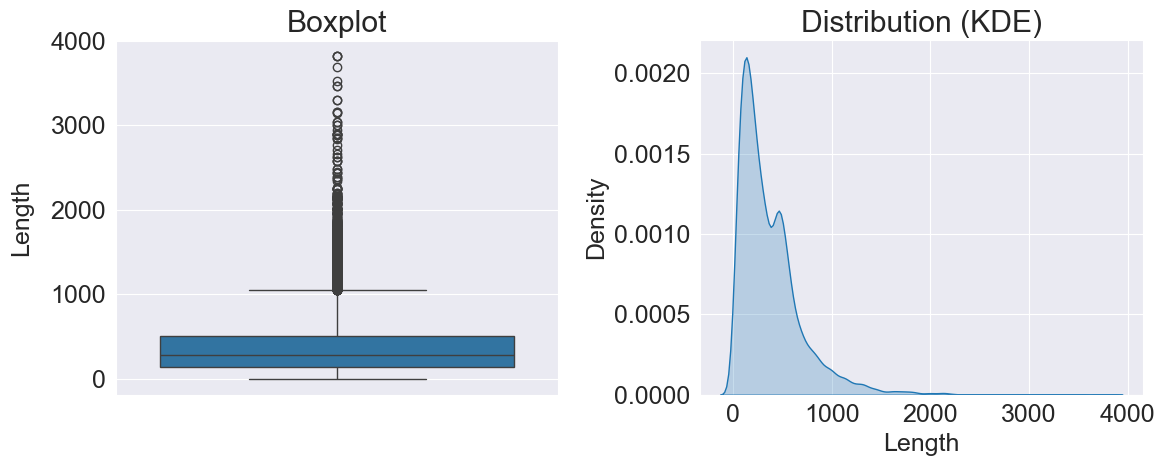

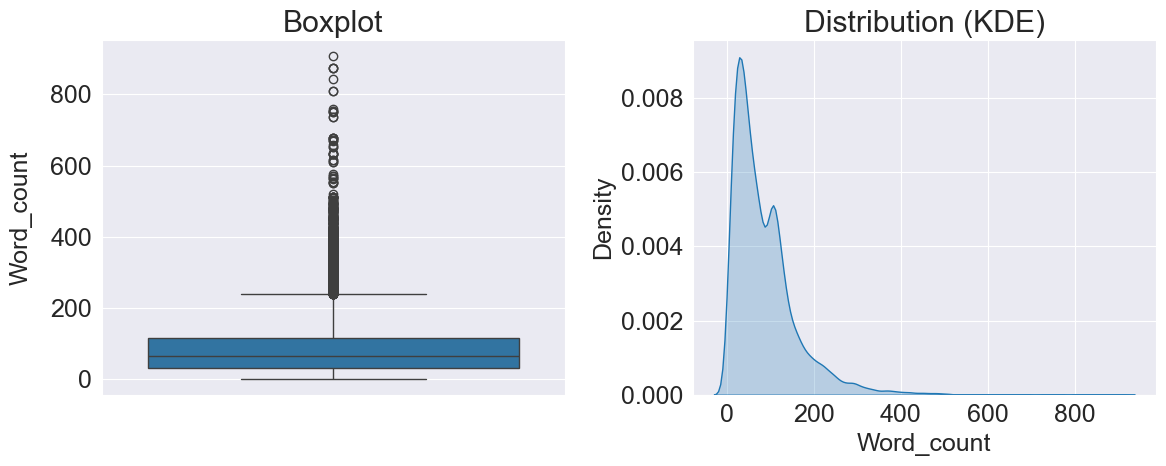

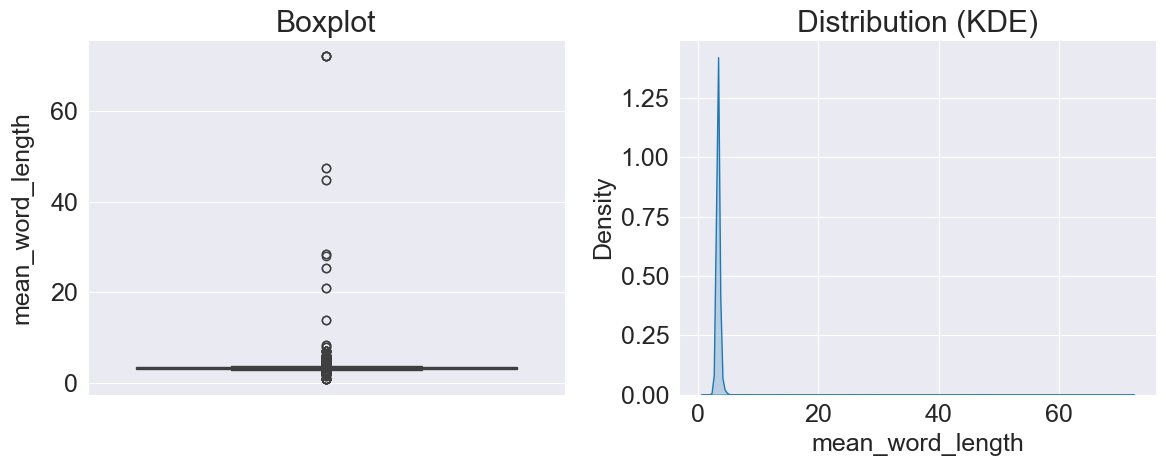

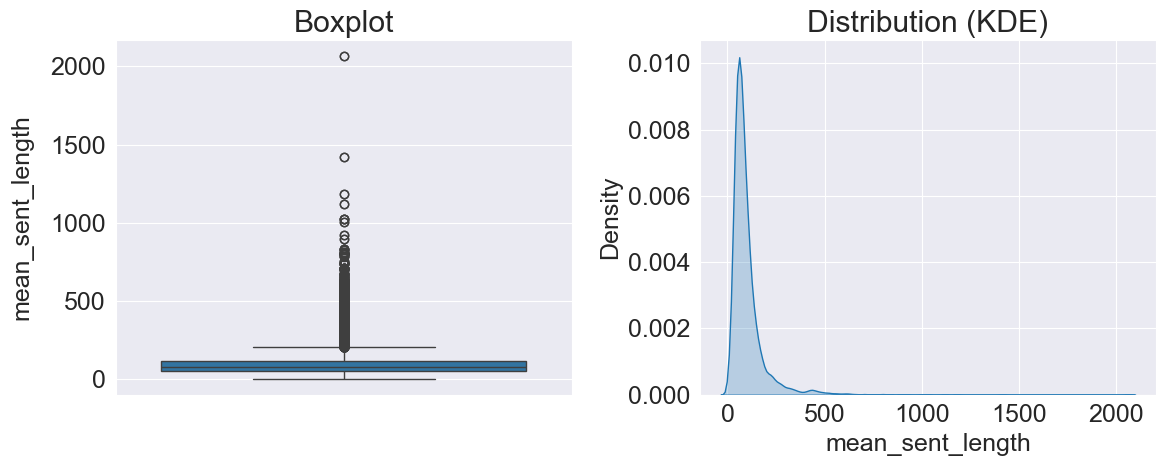

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize(col):
    plt.figure(figsize=(12,5))
    
    # Boxplot
    plt.subplot(1,2,1)
    sns.boxplot(y=data[col])
    plt.ylabel(col, labelpad=12.5)
    plt.title("Boxplot")
    
    # KDE (toàn bộ dữ liệu)
    plt.subplot(1,2,2)
    sns.kdeplot(data[col], fill=True)
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.title("Distribution (KDE)")
    
    plt.tight_layout()
    plt.show()

features = data.columns.tolist()[2:]
for feature in features:
    visualize(feature)


### Danh sách các từ

In [16]:
def corpus(text):
    text_list = text.split()
    return text_list

df = data.copy()
df['Comment_lists'] = df['Comment'].apply(corpus)
df.head(10)

,Comment,Rating,Length,Word_count,mean_word_length,mean_sent_length,Comment_lists
0,Món ăn cực tệ,0.0,13,4,2.500000,13.000000,"[Món, ăn, cực, tệ]"
1,Mình thấy mọi người review tích cực nhưng thực sự mình không thấy lẩu ở đây giống review. Lẩu đắt và chán thực sự. Never come back!,0.0,131,27,3.888889,43.000000,"[Mình, thấy, mọi, người, review, tích, cực, nhưng, thực, sự, mình, không, thấy, lẩu, ở, đây, giống, review., Lẩu, đắt, và, chán, thực, sự., Never, come, back!]"
2,"Chắc với sinh viên thì ai cũng quen thuộc với lẩu Nguyệt. Cứ có dịp gì tụ tập đông đông là nhóm mình lại qua đây ăn. Vừa ngon vừa rẻ. Quán thì phải kéo dài từ vỉa hè đến cả trong ngõ 106, có cả ngồi dưới nhà và đi thang máy lên tầng tùy mình muốn chọn ngồi đâu thì ngồi.\n Quán cũng chỉ có 2 loại lẩu: lẩu riêu cua và lẩu hải sản. Nhân viên thường lấy đồ theo kiểu 100k/ người. Lẩu riêu cua nếu đi 7 người thì cũng chỉ gọi phần cho 5 người thôi, không sẽ không hết vì quá nhiều )). Thường bọn mình sẽ gọi thêm 1 đĩa lòng, tràng, trứng gà non 100k/ đĩa ăn kèm. Còn lẩu hải sản cũng khá đầy đặn 350k/ nồi. Quán cũng bán thêm quẩy ăn kèm lẩu nữa. Nói chung ăn ở đây cứ chia đầu người 120k là no lắm rồi ý ^^.",1.0,704,162,3.345679,63.000000,"[Chắc, với, sinh, viên, thì, ai, cũng, quen, thuộc, với, lẩu, Nguyệt., Cứ, có, dịp, gì, tụ, tập, đông, đông, là, nhóm, mình, lại, qua, đây, ăn., Vừa, ngon, vừa, rẻ., Quán, thì, phải, kéo, dài, từ, vỉa, hè, đến, cả, trong, ngõ, 106,, có, cả, ngồi, dưới, nhà, và, đi, thang, máy, lên, tầng, tùy, mình, muốn, chọn, ngồi, đâu, thì, ngồi., Quán, cũng, chỉ, có, 2, loại, lẩu:, lẩu, riêu, cua, và, lẩu, hải, sản., Nhân, viên, thường, lấy, đồ, theo, kiểu, 100k/, người., Lẩu, riêu, cua, nếu, đi, 7, người, thì, cũng, chỉ, gọi, phần, cho, 5, ...]"
3,"Nhiều hôm thèm lẩu riêu mà chỉ có một mình thì nên ra đây để ăn vì giá rổ rất phải chăng để có thể không cần đồng bọn.\nTết nhất ngán thịt thì có thể qua đây vì lẩu ở đây cực nhiều đậu. Thuộc thể loại ăn lẩu thích ăn rau nhiều hơn thịt nên quán này cực hợp với mình. Gọi nồi lẩu 2 người không thêm gì khác cũng đủ no căng bụng rồi. Topping ở đây còn có cả chả cá, chả bò, giò tai cực ngon. Ăn một người cũng hết 200k thui à.",1.0,423,100,3.240000,69.666667,"[Nhiều, hôm, thèm, lẩu, riêu, mà, chỉ, có, một, mình, thì, nên, ra, đây, để, ăn, vì, giá, rổ, rất, phải, chăng, để, có, thể, không, cần, đồng, bọn., Tết, nhất, ngán, thịt, thì, có, thể, qua, đây, vì, lẩu, ở, đây, cực, nhiều, đậu., Thuộc, thể, loại, ăn, lẩu, thích, ăn, rau, nhiều, hơn, thịt, nên, quán, này, cực, hợp, với, mình., Gọi, nồi, lẩu, 2, người, không, thêm, gì, khác, cũng, đủ, no, căng, bụng, rồi., Topping, ở, đây, còn, có, cả, chả, cá,, chả, bò,, giò, tai, cực, ngon., Ăn, một, người, cũng, hết, 200k, thui, à.]"
4,Không gian sạch sẽ.quán mới lên ra món hơi chậm.15p chờ cũng ko lâu lắm.nhưng đồ đều nóng thơm lừng.nhiều nữa chứ.,1.0,114,22,4.227273,114.000000,"[Không, gian, sạch, sẽ.quán, mới, lên, ra, món, hơi, chậm.15p, chờ, cũng, ko, lâu, lắm.nhưng, đồ, đều, nóng, thơm, lừng.nhiều, nữa, chứ.]"
5,Nhất định sẽ ủng hộ quán dài dài…,1.0,33,8,3.250000,33.000000,"[Nhất, định, sẽ, ủng, hộ, quán, dài, dài…]"
6,Lang thang với cái bụng đói.đứng chờ tàu thì ngó thấy.quay xe đi vào.lúc đầu nghĩ là nhầm quán cafe cơ.vì bàn ghê đẹp.có hai cô chỉ cũng đẹp luôn.đói mạnh dạn gọi hẳn đặc biệt 60k.\nĂn ngon nhiều.còn bán rượu khá ngon.đồ đủ để hai ng ngồi nhấm vài ly luôn.\nNói chung 5 sao,1.0,271,57,3.771930,89.666667,"[Lang, thang, với, cái, bụng, đói.đứng, chờ, tàu, thì, ngó, thấy.quay, xe, đi, vào.lúc, đầu, nghĩ, là, nhầm, quán, cafe, cơ.vì, bàn, ghê, đẹp.có, hai, cô, chỉ, cũng, đẹp, luôn.đói, mạnh, dạn, gọi, hẳn, đặc, biệt, 60k., Ăn, ngon, nhiều.còn, bán, rượu, khá, ngon.đồ, đủ, để, hai, ng, ngồi, nhấm, vài, ly, luôn., Nói, chung, 5, sao]"
7,"Cá thái quá to, rán cháy, cứng, khô.\nNước dùng chán, nhạt",0.0,57,12,3.833333,28.000000,"[Cá, thái, quá, to,, rán, cháy,, cứng,, khô., Nước, dùng, chán,, nhạt]"
8,"Đói quá vội ăn nên ko chụp đc cái ảnh tử tế. Phải nói là

In [17]:
corpus = []
for i in trange(df.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += df['Comment_lists'][i]
len(corpus)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 22841/22841 [00:00<00:00, 251077.40it/s]


1965125

In [18]:
mostCommon = Counter(corpus).most_common(10)
mostCommon

[('ăn', 36176),
 ('có', 26711),
 ('là', 26130),
 ('mình', 25419),
 ('thì', 21432),
 ('và', 21022),
 ('không', 18953),
 ('quán', 17270),
 ('cũng', 16760),
 ('nên', 14425)]

In [19]:
df['word_count'] = df['Comment'].apply(lambda x: len(x.split()))

min_words = df['word_count'].min()
max_words = df['word_count'].max()
mean_words = df['word_count'].mean()
median_words = df['word_count'].median()

print(f"Số từ tối thiểu trong câu: {min_words}")
print(f"Số từ tối đa trong câu: {max_words}")
print(f"Số từ trung bình trong câu: {mean_words:.2f}")
print(f"Số từ trung vị trong câu: {median_words}")

Số từ tối thiểu trong câu: 1
Số từ tối đa trong câu: 907
Số từ trung bình trong câu: 86.03
Số từ trung vị trong câu: 65.0


In [20]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)

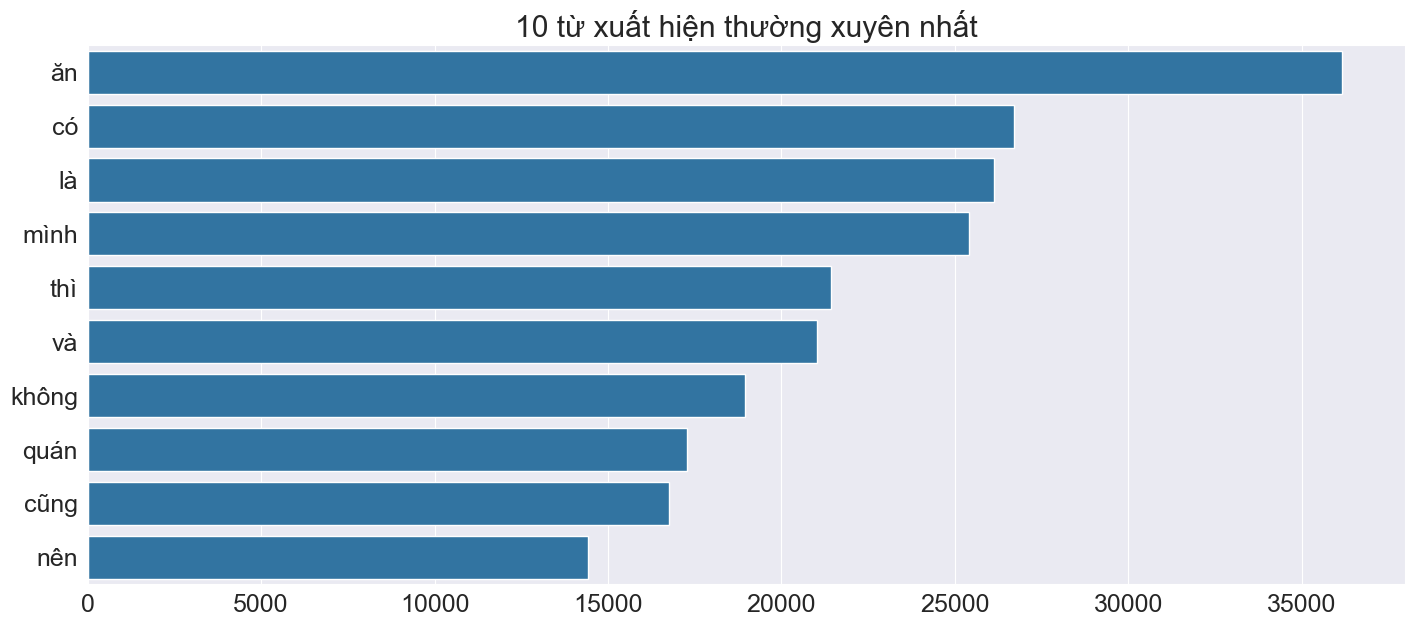

In [21]:
sns.barplot(x=freq, y=words)
plt.title('10 từ xuất hiện thường xuyên nhất')
plt.show()

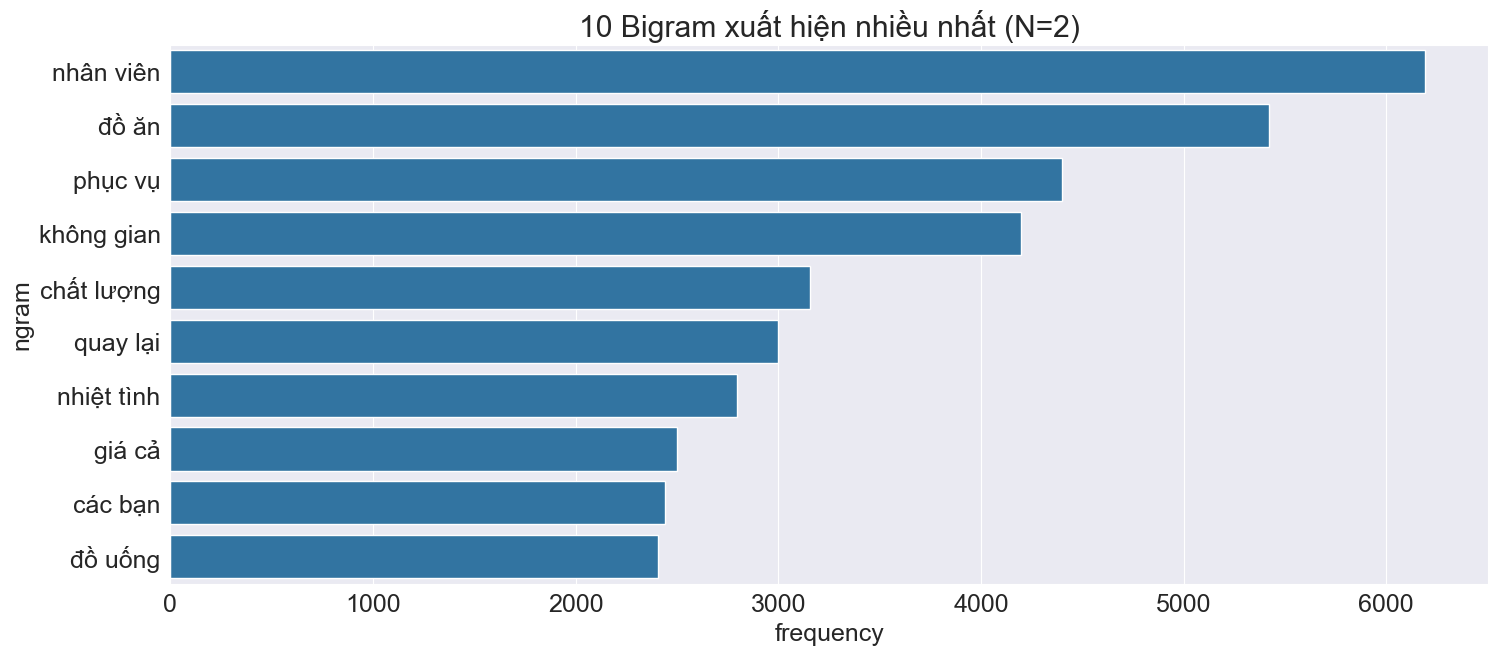

In [22]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df['Comment'])

count_values = bigrams.sum(axis=0).A1
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('10 Bigram xuất hiện nhiều nhất (N=2)')
plt.show()

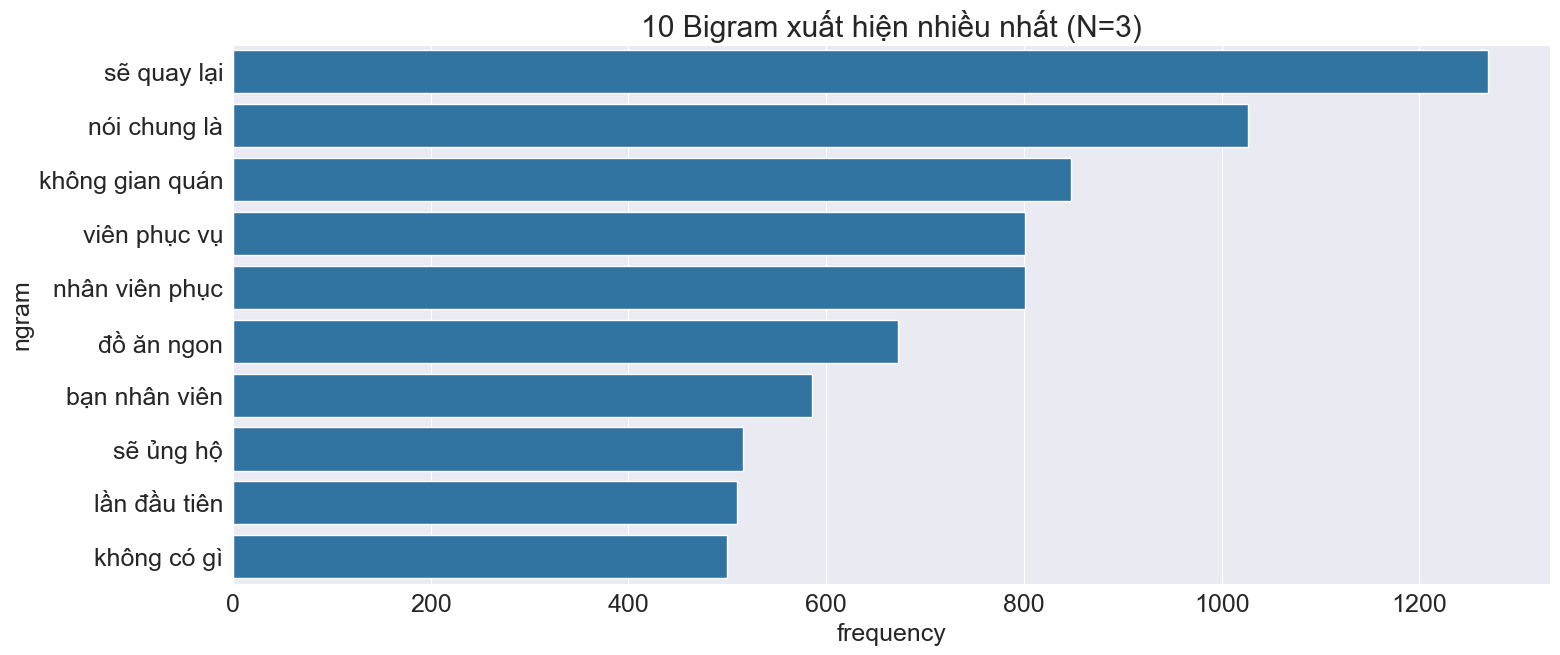

In [23]:
cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(df['Comment'])
count_values = trigrams.sum(axis=0).A1
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('10 Bigram xuất hiện nhiều nhất (N=3)')
plt.show()

# After pre-processing

In [24]:
df = pd.read_csv("Dataset/vsa_food_rv_train_clean.csv")

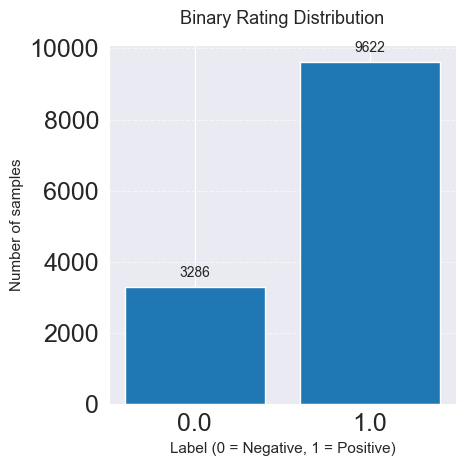

In [ ]:
import matplotlib.pyplot as plt

rating_counts = df['Rating'].value_counts().sort_index()

plt.figure(figsize=(5, 5))  
bars = plt.bar(
    rating_counts.index.astype(str),
    rating_counts.values
)

plt.xlabel("Label (0 = Negative, 1 = Positive)", fontsize=11)
plt.ylabel("Number of samples", fontsize=11)
plt.title("Binary Rating Distribution", fontsize=13, pad=15)  

plt.grid(axis='y', linestyle='--', alpha=0.6)

max_height = rating_counts.values.max()

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + max_height * 0.02,
        int(height),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

In [25]:
def corpus(text):
    text_list = text.split()
    return text_list

df['Comment_lists'] = df['Comment'].apply(lambda x: x.split())
df.head(10)

,Comment,Rating,word_count,Comment_lists
0,món ăn cực tệ,0.0,4,"[món, ăn, cực, tệ]"
1,mình thấy mọi người review tích cực nhưng thực sự mình không thấy lẩu ở đây giống review lẩu đắt và chán thực sự never come back !,0.0,28,"[mình, thấy, mọi, người, review, tích, cực, nhưng, thực, sự, mình, không, thấy, lẩu, ở, đây, giống, review, lẩu, đắt, và, chán, thực, sự, never, come, back, !]"
2,chắc với sinh viên thì ai cũng quen thuộc với lẩu nguyệt cứ có dịp gì tụ tập đông đông là nhóm mình lại qua đây ăn vừa ngon vừa rẻ quán thì phải kéo dài từ vỉa hè đến cả trong ngõ 106 có cả ngồi dưới nhà và đi thang máy lên tầng tùy mình muốn chọn ngồi đâu thì ngồi quán cũng chỉ có 2 loại lẩu lẩu riêu cua và lẩu hải sản nhân viên thường lấy đồ theo kiểu 100 ngàn/ người lẩu riêu cua nếu đi 7 người thì cũng chỉ gọi phần cho 5 người thôi không sẽ không hết vì quá nhiều )) thường bọn mình sẽ gọi thêm 1 đĩa lòng tràng trứng gà non 100 ngàn/ đĩa ăn kèm còn lẩu hải sản cũng khá đầy đặn 350 ngàn/ nồi quán cũng bán thêm quẩy ăn kèm lẩu nữa nói chung ăn ở đây cứ chia đầu người 120 ngàn là no lắm rồi ý ^^,1.0,166,"[chắc, với, sinh, viên, thì, ai, cũng, quen, thuộc, với, lẩu, nguyệt, cứ, có, dịp, gì, tụ, tập, đông, đông, là, nhóm, mình, lại, qua, đây, ăn, vừa, ngon, vừa, rẻ, quán, thì, phải, kéo, dài, từ, vỉa, hè, đến, cả, trong, ngõ, 106, có, cả, ngồi, dưới, nhà, và, đi, thang, máy, lên, tầng, tùy, mình, muốn, chọn, ngồi, đâu, thì, ngồi, quán, cũng, chỉ, có, 2, loại, lẩu, lẩu, riêu, cua, và, lẩu, hải, sản, nhân, viên, thường, lấy, đồ, theo, kiểu, 100, ngàn/, người, lẩu, riêu, cua, nếu, đi, 7, người, thì, cũng, chỉ, gọi, phần, cho, ...]"
3,nhiều hôm thèm lẩu riêu mà chỉ có một mình thì nên ra đây để ăn vì giá rổ rất phải chăng để có thể không cần đồng bọn tết nhất ngán thịt thì có thể qua đây vì lẩu ở đây cực nhiều đậu thuộc thể loại ăn lẩu thích ăn rau nhiều hơn thịt nên quán này cực hợp với mình gọi nồi lẩu 2 người không thêm gì khác cũng đủ no căng bụng rồi topping ở đây còn có cả chả cá chả bò giò tai cực ngon ăn một người cũng hết 200 ngàn thôi à,1.0,101,"[nhiều, hôm, thèm, lẩu, riêu, mà, chỉ, có, một, mình, thì, nên, ra, đây, để, ăn, vì, giá, rổ, rất, phải, chăng, để, có, thể, không, cần, đồng, bọn, tết, nhất, ngán, thịt, thì, có, thể, qua, đây, vì, lẩu, ở, đây, cực, nhiều, đậu, thuộc, thể, loại, ăn, lẩu, thích, ăn, rau, nhiều, hơn, thịt, nên, quán, này, cực, hợp, với, mình, gọi, nồi, lẩu, 2, người, không, thêm, gì, khác, cũng, đủ, no, căng, bụng, rồi, topping, ở, đây, còn, có, cả, chả, cá, chả, bò, giò, tai, cực, ngon, ăn, một, người, cũng, hết, 200, ngàn, thôi, ...]"
4,không gian sạch sẽ quán mới lên ra món hơi chậm 15 phút chờ cũng không lâu lắm nhưng đồ đều nóng thơm lừng nhiều nữa chứ,1.0,27,"[không, gian, sạch, sẽ, quán, mới, lên, ra, món, hơi, chậm, 15, phút, chờ, cũng, không, lâu, lắm, nhưng, đồ, đều, nóng, thơm, lừng, nhiều, nữa, chứ]"
5,nhất định sẽ ủng hộ quán dài dài…,1.0,8,"[nhất, định, sẽ, ủng, hộ, quán, dài, dài…]"
6,lang thang với cái bụng đói đứng chờ tàu thì ngó thấy quay xe đi vào lúc đầu nghĩ là nhầm quán cafe cơ vì bàn ghê đẹp có hai cô chỉ cũng đẹp luôn đói mạnh dạn gọi hẳn đặc biệt 60 ngàn ăn ngon nhiều còn bán rượu khá ngon đồ đủ để hai người ngồi nhấm vài ly luôn nói chung 5 sao,1.0,66,"[lang, thang, với, cái, bụng, đói, đứng, chờ, tàu, thì, ngó, thấy, quay, xe, đi, vào, lúc, đầu, nghĩ, là, nhầm, quán, cafe, cơ, vì, bàn, ghê, đẹp, có, hai, cô, chỉ, cũng, đẹp, luôn, đói, mạnh, dạn, gọi, hẳn, đặc, biệt, 60, ngàn, ăn, ngon, nhiều, còn, bán, rượu, khá, ngon, đồ, đủ, để, hai, người, ngồi, nhấm, vài, ly, luôn, nói, chung, 5, sao]"
7,cá thái quá to rán cháy cứng khô nước dùng chán nhạt,0.0,12,"[cá, thái, quá, to, rán, cháy, cứng, khô, nước, dùng, chán, nhạt]"
8,đói quá vội ăn nên không chụp được cái ảnh tử tế phải nói là bún cá ở đây ngon nhất trong các quán đã ăn mình ăn thử rất rất nhiều quán cả các quán nổi tiếng lẫn các quán nhỏ nhưng không ở đâu làm ổn như ở đây nước dùng đậm đà màu sắc bắt mắt chứ không trắng nhởn như nhiều quán

In [26]:
corpus = []
for i in trange(df.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += df['Comment_lists'][i]
len(corpus)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 12908/12908 [00:00<00:00, 261510.89it/s]


1131618

In [27]:
mostCommon = Counter(corpus).most_common(10)
mostCommon

[('ăn', 23365),
 ('không', 21199),
 ('mình', 20147),
 ('có', 16287),
 ('là', 15012),
 ('quán', 13506),
 ('thì', 12420),
 ('và', 12306),
 ('ngon', 10725),
 ('cũng', 9975)]

In [28]:
df['word_count'] = df['Comment'].apply(lambda x: len(x.split()))

min_words = df['word_count'].min()
max_words = df['word_count'].max()
mean_words = df['word_count'].mean()
median_words = df['word_count'].median()

print(f"Số từ tối thiểu trong câu: {min_words}")
print(f"Số từ tối đa trong câu: {max_words}")
print(f"Số từ trung bình trong câu: {mean_words:.2f}")
print(f"Số từ trung vị trong câu: {median_words}")

Số từ tối thiểu trong câu: 1
Số từ tối đa trong câu: 919
Số từ trung bình trong câu: 87.67
Số từ trung vị trong câu: 66.0


In [29]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)

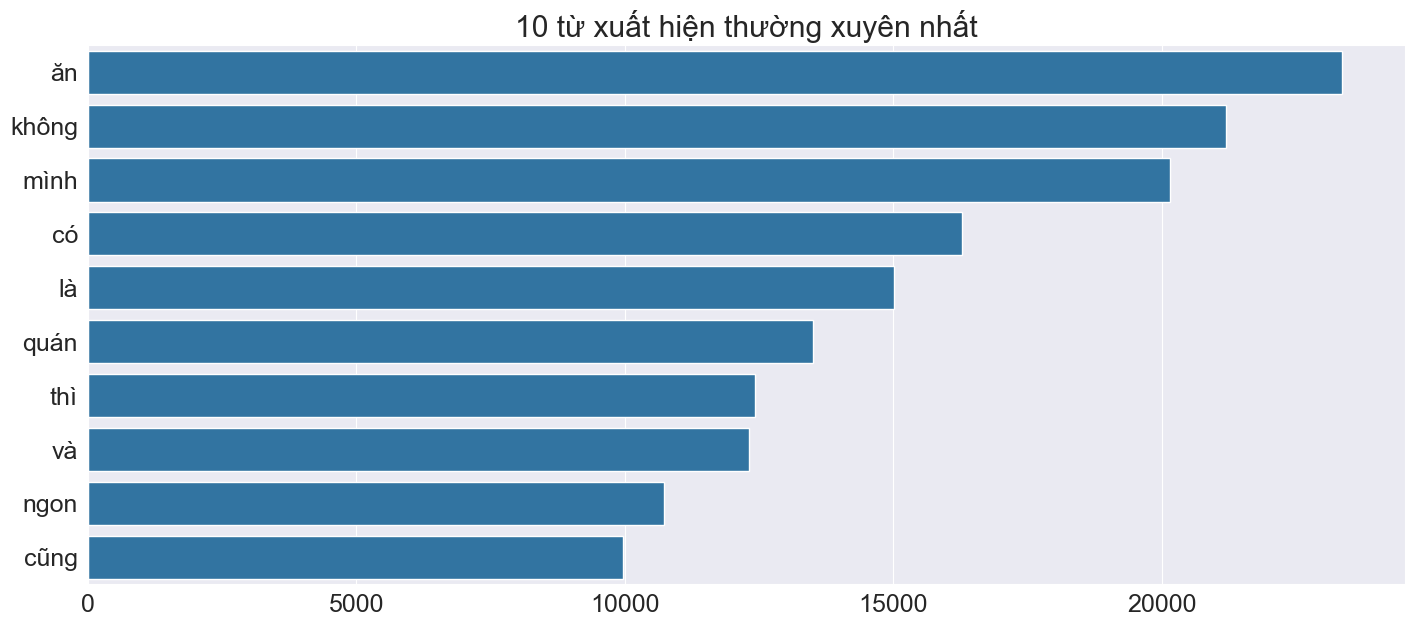

In [30]:
sns.barplot(x=freq, y=words)
plt.title('10 từ xuất hiện thường xuyên nhất')
plt.show()

### Các N-gram xuất hiện thường xuyên nhất

In [31]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df['Comment'])

count_values = bigrams.sum(axis=0).A1
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

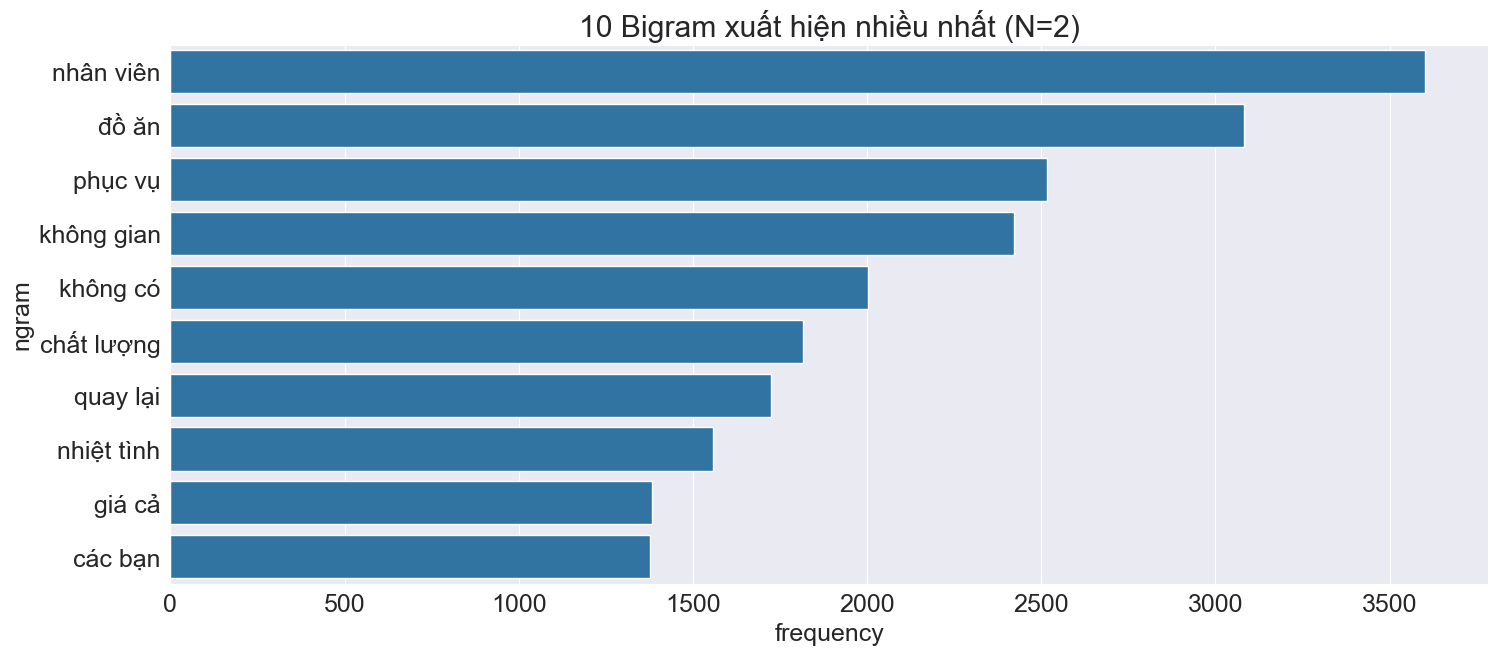

In [32]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('10 Bigram xuất hiện nhiều nhất (N=2)')
plt.show()

In [33]:
cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(df['Comment'])
count_values = trigrams.sum(axis=0).A1
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

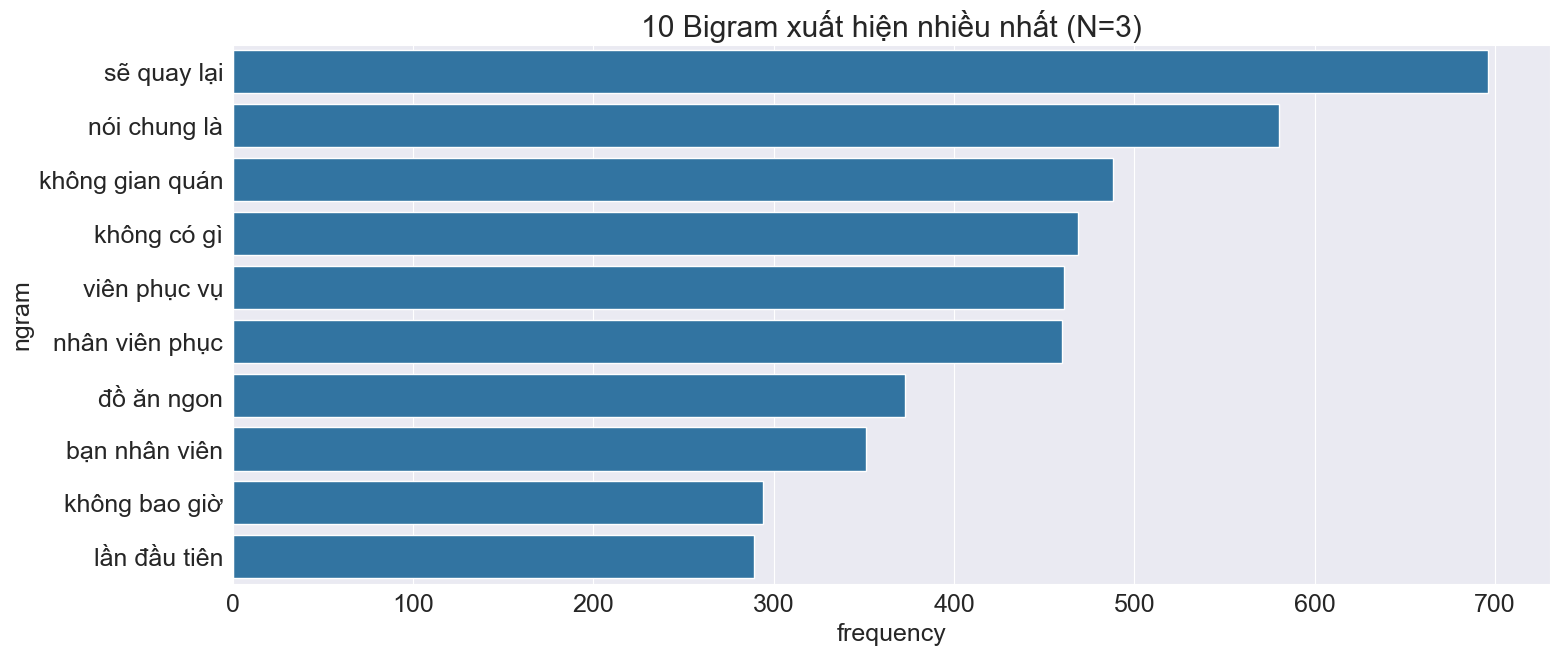

In [34]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('10 Bigram xuất hiện nhiều nhất (N=3)')
plt.show()